In [1]:
import numpy as np
import scipy.io as scio
import scipy.stats as st
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import dendrogram
# Below is just a faster version of clustering than in scipy.cluster.hierarchy
# Source: https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
from fastcluster import linkage

from sklearn.decomposition import PCA

In [2]:
# Set the font size for plots
FS=40
plt.rcParams.update({'font.size': 40})

# Set the linewidth for plots
plt.rcParams['lines.linewidth'] = 5

Load p3 and p7 connectivity matrices, and their corresponding cf (row) and pc (column) labels

In [3]:
p3fc = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P3_Observed_PC_Connectivity_Synapse_Numbers_gteq_5_syns_gteq_40pc_PC_targets.mat' # connectivity matrix
p3fa = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P3_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat' # axon ids
p3fp = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P3_PC_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_40pc_PC_syns.mat' # pc ids

In [4]:
p7fc = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P7_Observed_PC_Connectivity_Synapse_Numbers_gteq_5_syns_gteq_70pc_PC_targets.mat' # connectivity matrix
p7fa = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P7_axon_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat' # axon ids
p7fp = '/usr/people/amw7/pinky_analysis/cerebellum/181227_analysis_conn-based_ax_cuts/connectivity_matrices/P7_PC_IDs_for_Obs_PC_Conn_Syn_Nums_gteq_5_syns_gteq_70pc_PC_syns.mat' # pc ids

In [5]:
p3cdict = scio.loadmat(p3fc)
p3adict = scio.loadmat(p3fa)
p3pdict = scio.loadmat(p3fp)

p7cdict = scio.loadmat(p7fc)
p7adict = scio.loadmat(p7fa)
p7pdict = scio.loadmat(p7fp)

In [6]:
p3c = p3cdict['P3_PCconnectivity']
p3a = p3adict['P3_PCconn_axon_IDs']
p3p = p3pdict['P3_PCconn_PC_IDs']

p7c = p7cdict['P7_PCconnectivity']
p7a = p7adict['P7_PCconn_axon_IDs']
p7p = p7pdict['P7_PCconn_PC_IDs']

Start by inspecting the p7 connectivity matrix overall (where preferences for particular targets have apparently manifested, based on our other analysis).

View each row as a feature vector for an observed cf. Create a distance matrix for these observations and see whether you can group them into clusters.

Also, just reorder the actual connectivity matrix so it is in block-diagonal form

In [7]:
# p7c.shape # debugging

Next, take a subset of cfs from the p7 data that have more likely established preferences and check their similarities

Our criterion for a cf with at least one strong preference is that it forms > the 99th percentile of synapses per pc at p3 onto at least one pc

In [8]:
# p3cnz = p3c.flatten()
# p3cnz = [q for q in p3cnz if q != 0]

In [9]:
# p3_bin_edges = np.arange(-5,155,10)*0.1
# plt.figure()
# plt.hist(p3cnz,bins=p3_bin_edges)
# plt.xlabel('number of synapses per cf-pc pair')
# plt.ylabel('number of occurrences')
# plt.title('p3, distribution of n syns per cf-pc pair')
# plt.show()

Inspect the connectivity matrix for all inputs and for only those inputs that have established synaptic preferences for at least one Purkinje cell

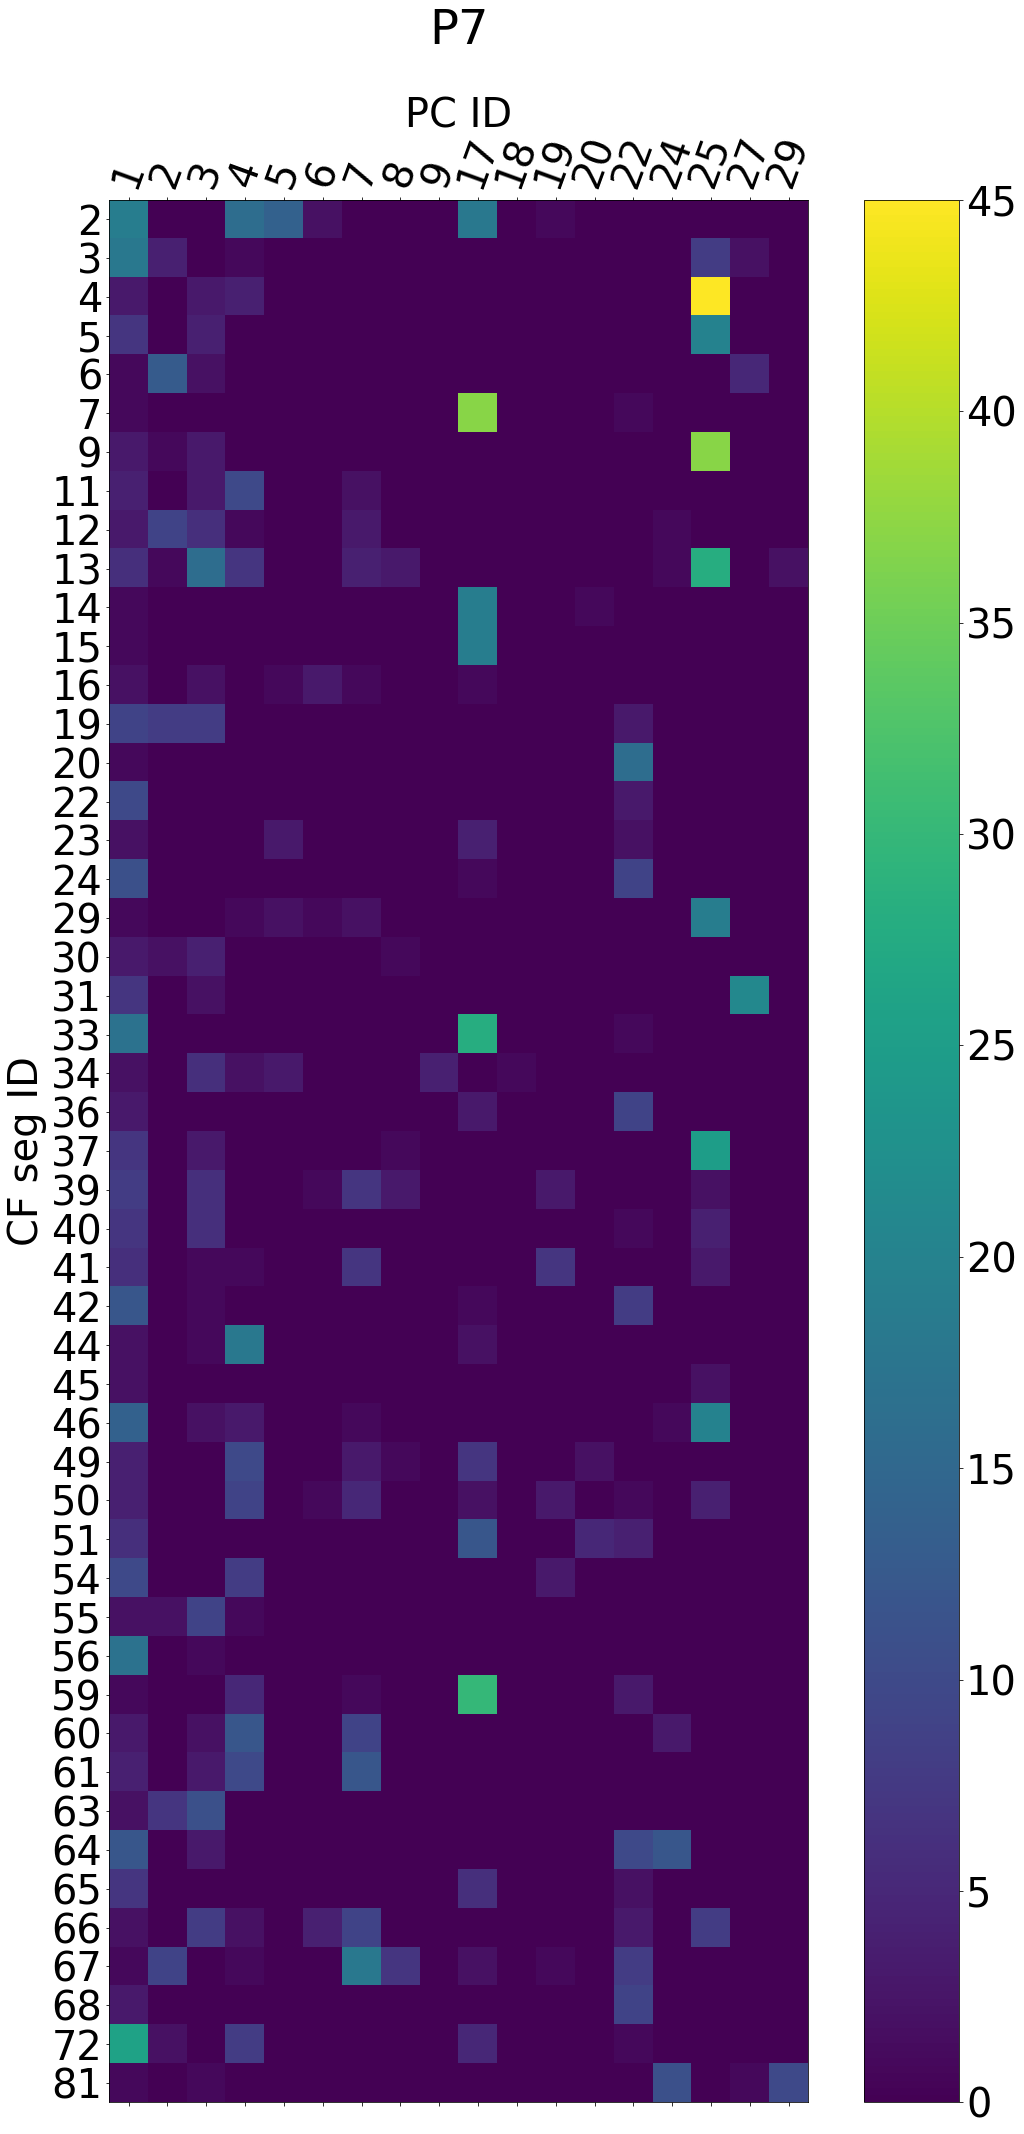

In [10]:
allp7cflabels = [str(q[0]) for q in p7a]
allp7pclabels = [str(q[0]) for q in p7p]

fig = plt.figure(figsize=(20,35))
ax = fig.add_subplot(111)
cax = ax.matshow(p7c)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7c.shape[1])])
ax.set_yticks([q for q in range(p7c.shape[0])])
ax.set_xticklabels(allp7pclabels,rotation=70)
ax.set_yticklabels(allp7cflabels,rotation=0)
ax.set_xlabel('PC ID')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('CF seg ID')
ax.set_title('P7\n')
fname = 'data/figures/conn_matrices/190307_p7_conn_mat.png'
# plt.show()
plt.savefig(fname)

In [11]:
p7cnz = p7c.flatten()
p7cnz = [q for q in p7cnz if q != 0]

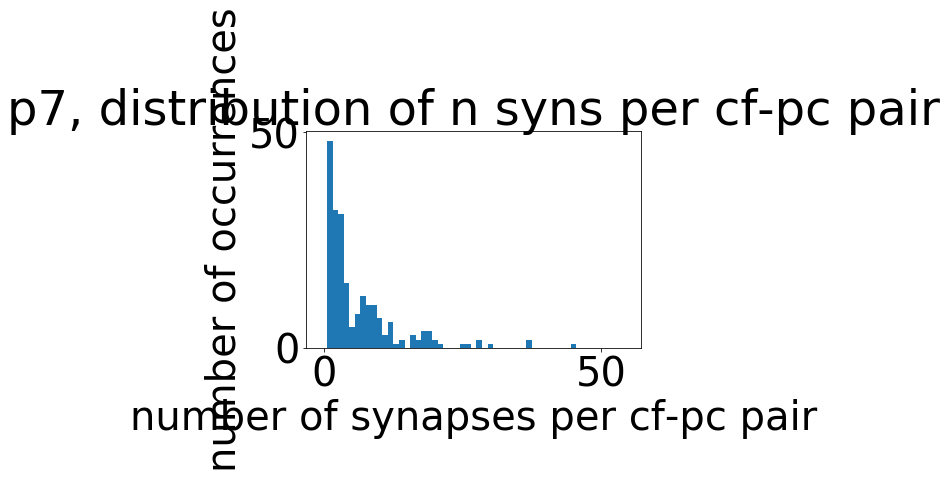

In [12]:
p7_bin_edges = np.arange(-5,555,10)*0.1
plt.figure()
plt.hist(p7cnz,bins=p7_bin_edges)
plt.xlabel('number of synapses per cf-pc pair')
plt.ylabel('number of occurrences')
plt.title('p7, distribution of n syns per cf-pc pair')
plt.show()

In this iteration, include all cfs, regardless of whether they form a lot of synapses

In [13]:
# this gives the tail of the p7 distribution
# minnsyns = 0 # case 1: no restrictions on the cf segs being analyzed
minnsyns = int(np.ceil(np.percentile(p7cnz,[90]).tolist()[0])) # case 2: analyze cfs forming more than the 90th percentile of p7 values
# minnsyns = int(np.max(p3cnz)) # case 3: greater than any p3 values
# minnsyns = int(np.ceil(np.percentile(p3cnz,[99]).tolist()[0])) # case 4: more than the 99th percentile of p3 values
print(minnsyns) # inspecting values

16


In [14]:
rs,cs = np.where(p7c > minnsyns)
p7rowsl = list(set(rs))
# len(p7rowsl) # debugging

In [15]:
rsdel = [q for q in range(p7c.shape[0]) if not np.isin(q,p7rowsl)]
p7clnn = np.delete(p7c,rsdel,axis=0) # non-normalized
p7al = np.delete(p7a,rsdel,axis=0)
p7clnn.shape # debugging

(19, 18)

IMPORTANT: Normalize the feature vectors for the block diagonal analysis here (or else the distances will be large for vectors that point on the same line--i.e. that have the same relative connectivity properties--but form different numbers of synapses onto their targets. we want pairs of this type to have a distance of 0 and be grouped together).

In [16]:
normfacts = np.expand_dims(np.sum(p7clnn,axis=1),axis=1)
normfactmatrix = np.tile(normfacts,(1,p7clnn.shape[1]))
p7cl = np.divide(p7clnn,normfactmatrix)
# print(np.sum(p7cl,axis=1)) # debugging

Inspect the reduced connectivity matrix (containing cfs that form large numbers of synapses only)

In [17]:
p7cflabels = [str(q[0]) for q in p7al]
p7pclabels = [str(q[0]) for q in p7p]

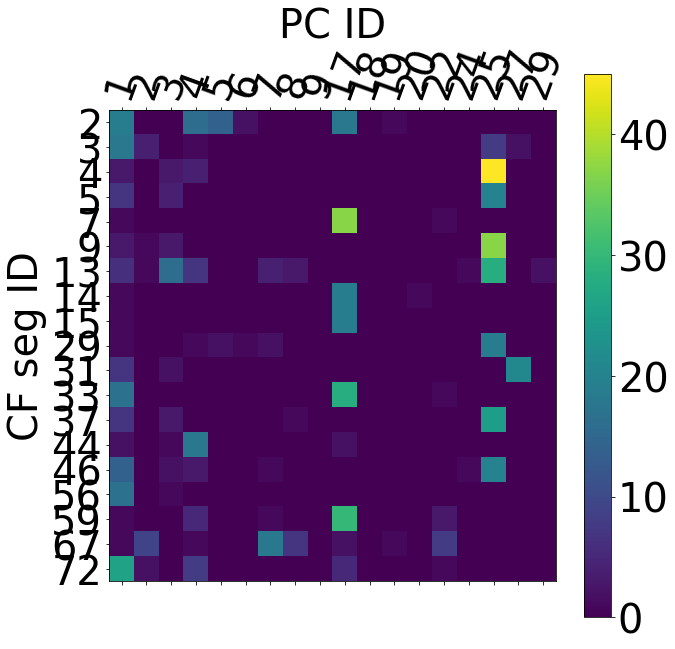

In [18]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(p7clnn)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7clnn.shape[1])])
ax.set_yticks([q for q in range(p7clnn.shape[0])])
ax.set_xticklabels(p7pclabels,rotation=70)
ax.set_yticklabels(p7cflabels,rotation=0)
ax.set_xlabel('PC ID')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('CF seg ID')
plt.show()

Compute the Euclidean distance matrix for the normalized p7 large-synapse connectivity matrix

In [19]:
p7cld = pdist(p7cl,'euclidean')

Inspect the distance matrix

In [20]:
p7cldsq = squareform(p7cld)

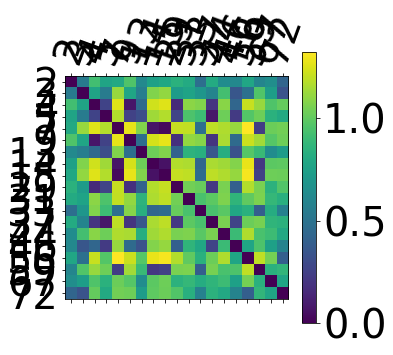

In [21]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(p7cldsq)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7cldsq.shape[0])])
ax.set_yticks([q for q in range(p7cldsq.shape[0])])
ax.set_xticklabels(p7cflabels,rotation=70)
ax.set_yticklabels(p7cflabels,rotation=0)
plt.show()

Re-order distance matrix rows and columns to look for block diagonal form

One way to do this re-ordering is to perform hierarchical clustering on the elements based on their distance matrix, and then to arrange them in the ordering given by hierarchical clustering.

In [22]:
# Source: https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))

Order large-synapse cfs according to their hierarchical clustering position.

In [23]:
# Code modified from the following source
# https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
def compute_serial_matrix(dist_mat,method="ward",metric="euclidean"):
    '''
        input:
            - flat_dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method, metric=metric)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros([N,N])
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [24]:
p7lno,p7lneworder,p7link = compute_serial_matrix(p7cldsq,method='ward',metric='euclidean')
# Re-order the climbing fiber segment labels
p7lcfnolabels = [str(p7al[q][0]) for q in p7lneworder]

# test code for understanding how the function above works
# N = len(p7cldsq)
# p7lneworder = seriation(p7link,N, N + N-2)
# p7lno = np.zeros([N,N])
# a,b = np.triu_indices(N,k=1)
# Re-order the distance matrix elements using this order
# p7lno[a,b] = p7cldsq[ [p7lneworder[i] for i in a], [p7lneworder[j] for j in b]]
# p7lno[b,a] = p7lno[a,b]

In [25]:
p7lneworder

[16, 7, 4, 8, 9, 2, 5, 6, 14, 3, 12, 15, 1, 18, 10, 13, 17, 0, 11]

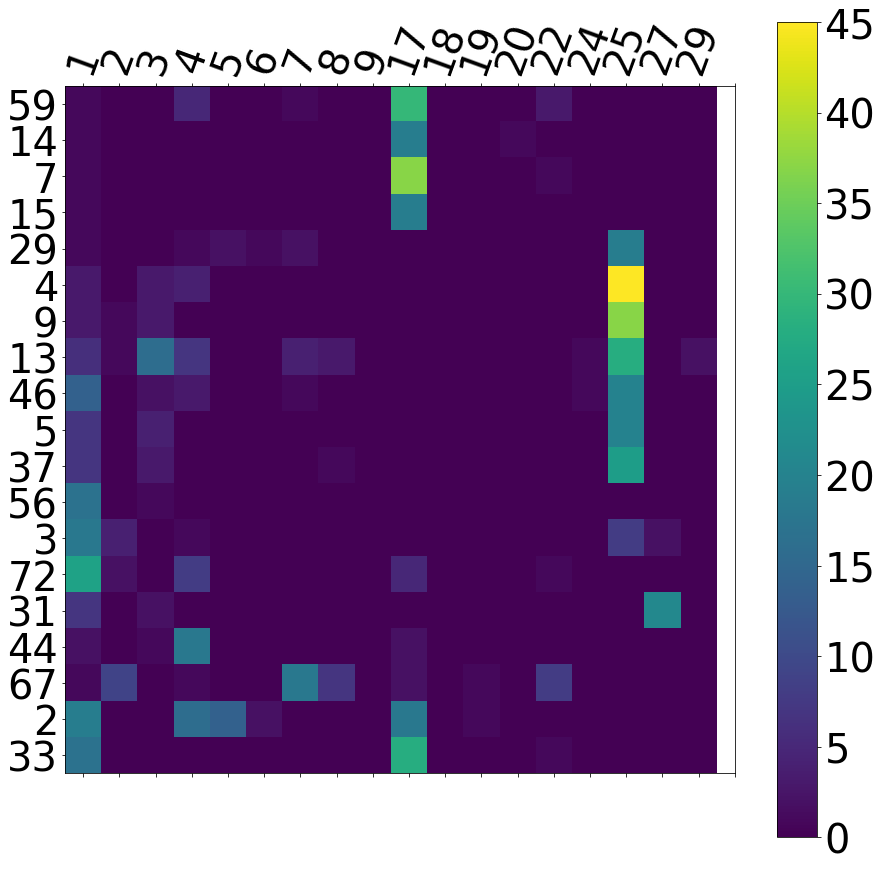

In [61]:
p7nn = np.asarray([p7clnn[q,:] for q in p7lneworder])
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)
cax = ax.matshow(p7nn)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7nn.shape[0])])
ax.set_yticks([q for q in range(p7nn.shape[0])])
ax.set_xticklabels(p7pclabels,rotation=70)
ax.set_yticklabels(p7lcfnolabels,rotation=0)
plt.show()

In [74]:
# Inspect the total numbers of synapses formed by each group onto its preferred Purkinje cell
rowsg1_nsyns = list(np.arange(4))
rowsg2_nsyns = list(np.arange(4,11))
rowsg3_nsyns = list(np.arange(11,14))
# print(rowsg1_nsyns,rowsg2_nsyns,rowsg3_nsyns) # debugging
# print(type(p7pclabels[0])) # debugging

g1prefid = [i for i,q in enumerate(p7pclabels) if q == '17']
g2prefid = [i for i,q in enumerate(p7pclabels) if q == '25']
g3prefid = [i for i,q in enumerate(p7pclabels) if q == '1']
print(g1prefid,g2prefid,g3prefid) # debugging

# Inspect the total number of synapses formed by the climbing fiber branches in each group
# onto all of their Purkinje cell targets
g1nsynstot = np.sum(np.asarray([p7nn[q,:] for q in rowsg1_nsyns]))
g2nsynstot = np.sum(np.asarray([p7nn[q,:] for q in rowsg2_nsyns]))
g3nsynstot = np.sum(np.asarray([p7nn[q,:] for q in rowsg3_nsyns]))
print(g1nsynstot,g2nsynstot,g3nsynstot) # debugging

# Inspect the total number of synapses formed by the climbing fiber branches in each group
# onto their preferred Purkinje cell target
g1nsynspref = np.sum(np.asarray([p7nn[q,g1prefid] for q in rowsg1_nsyns]))
g2nsynspref = np.sum(np.asarray([p7nn[q,g2prefid] for q in rowsg2_nsyns]))
g3nsynspref = np.sum(np.asarray([p7nn[q,g3prefid] for q in rowsg3_nsyns]))
print(g1nsynspref,g2nsynspref,g3nsynspref) # debugging

# Inspect the total number of synapses formed by the climbing fiber branches in each group
# onto the fully reconstructed Purkinje cell
g1nsynsfr = np.sum(np.asarray([p7nn[q,0] for q in rowsg1_nsyns]))
g2nsynsfr = np.sum(np.asarray([p7nn[q,0] for q in rowsg2_nsyns]))
g3nsynsfr = np.sum(np.asarray([p7nn[q,0] for q in rowsg3_nsyns]))
print(g1nsynsfr,g2nsynsfr,g3nsynsfr) # debugging

[9] [15] [0]
120 301 93
105 194 61
4 41 61


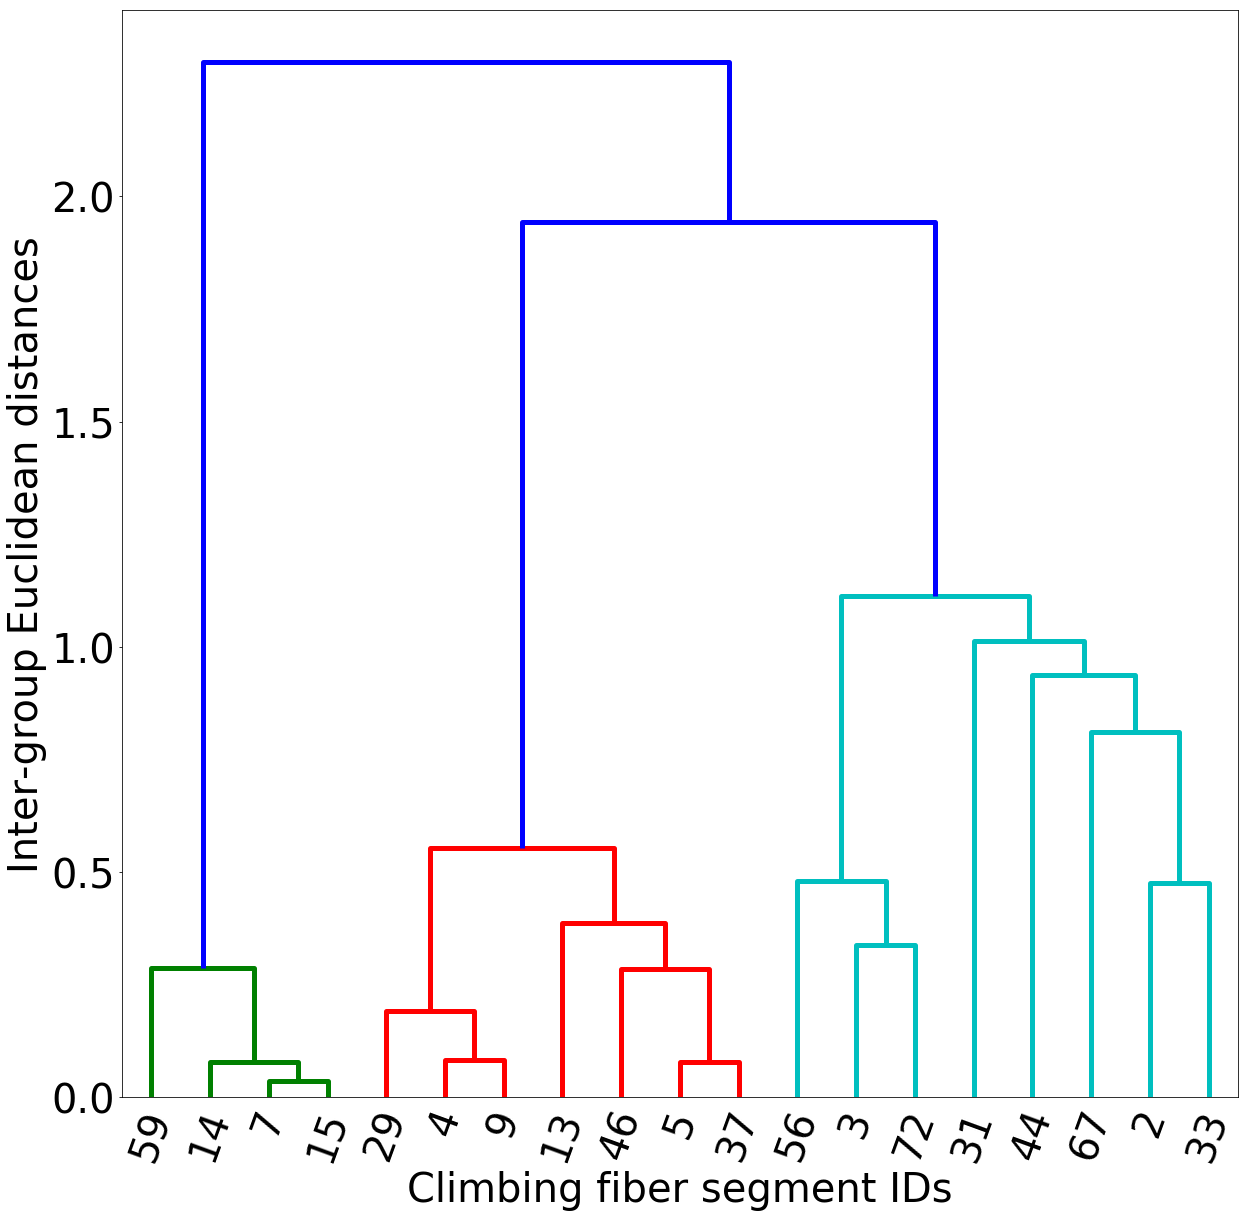

In [27]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
dn = dendrogram(p7link)
cflabelsforfig = [p7al[q][0] for q in dn['leaves']]
ax.set_xticklabels(cflabelsforfig,rotation=70)
ax.set_xlabel('Climbing fiber segment IDs')
ax.set_ylabel('Inter-group Euclidean distances')
plt.tick_params(labelsize=FS)
# Compute distribution metrics
dg_dists_obs = [q[1]-q[0] for q in dn['dcoord']] # the dists between clusters
dgd_med_obs = np.median(dg_dists_obs)
dgd_skew_obs = st.skew(dg_dists_obs)
dgd_std_obs = np.std(dg_dists_obs)
dgd_90pc_obs = np.percentile(dg_dists_obs,90)
dgd_95pc_obs = np.percentile(dg_dists_obs,95)
dgd_99pc_obs = np.percentile(dg_dists_obs,99)
hc_obs_fname = './data/figures/pc_prefs/190214_p7_obs_hier_clust_euc_dist_feat_vect_conn_mat.png'
# plt.show()
plt.savefig(hc_obs_fname)

In [28]:
# inspect the cf seg ids that correspond to each of the leaves (which are the ids of the original,
# unordered distance matrix, which are ids for the unordered cf labels
print([q for q in dn['leaves']])
print(cflabelsforfig)

[16, 7, 4, 8, 9, 2, 5, 6, 14, 3, 12, 15, 1, 18, 10, 13, 17, 0, 11]
[59, 14, 7, 15, 29, 4, 9, 13, 46, 5, 37, 56, 3, 72, 31, 44, 67, 2, 33]


In [29]:
# # inspect these bar heights to make sure they are reasonable
# # these are the distances between the linked groups (after normalizing)
# check = [q[1] - q[0] for q in dn['dcoord']]
# print(check)
# plt.figure()
# plt.hist(check)
# plt.show()

Inspect newly ordered matrix

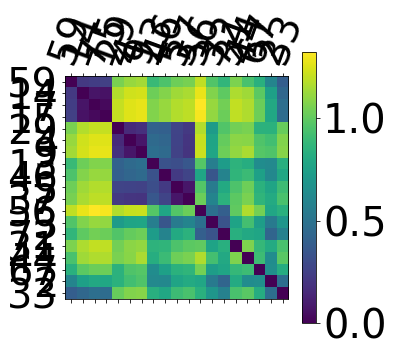

In [30]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(p7lno)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7lno.shape[0])])
ax.set_yticks([q for q in range(p7lno.shape[0])])
ax.set_xticklabels(p7lcfnolabels,rotation=70)
ax.set_yticklabels(p7lcfnolabels,rotation=0)
plt.show()

Check what the rows and columns of this actual matrix look like when they are in this order in the adjacency matrix (so with feature vectors showing)

In [31]:
p7clno = p7cl[p7lneworder,:]

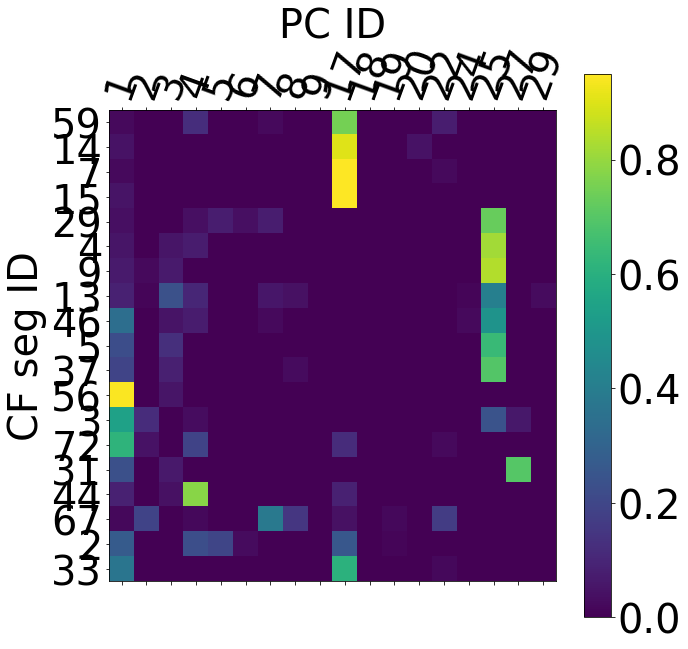

In [32]:
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(p7clno)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7clno.shape[1])])
ax.set_yticks([q for q in range(p7clno.shape[0])])
ax.set_xticklabels(p7pclabels,rotation=70)
ax.set_yticklabels(p7lcfnolabels,rotation=0)
ax.set_xlabel('PC ID')
ax.xaxis.set_label_position('top') 
ax.set_ylabel('CF seg ID')
plt.show()

Rank PCs according to descending preference for each group

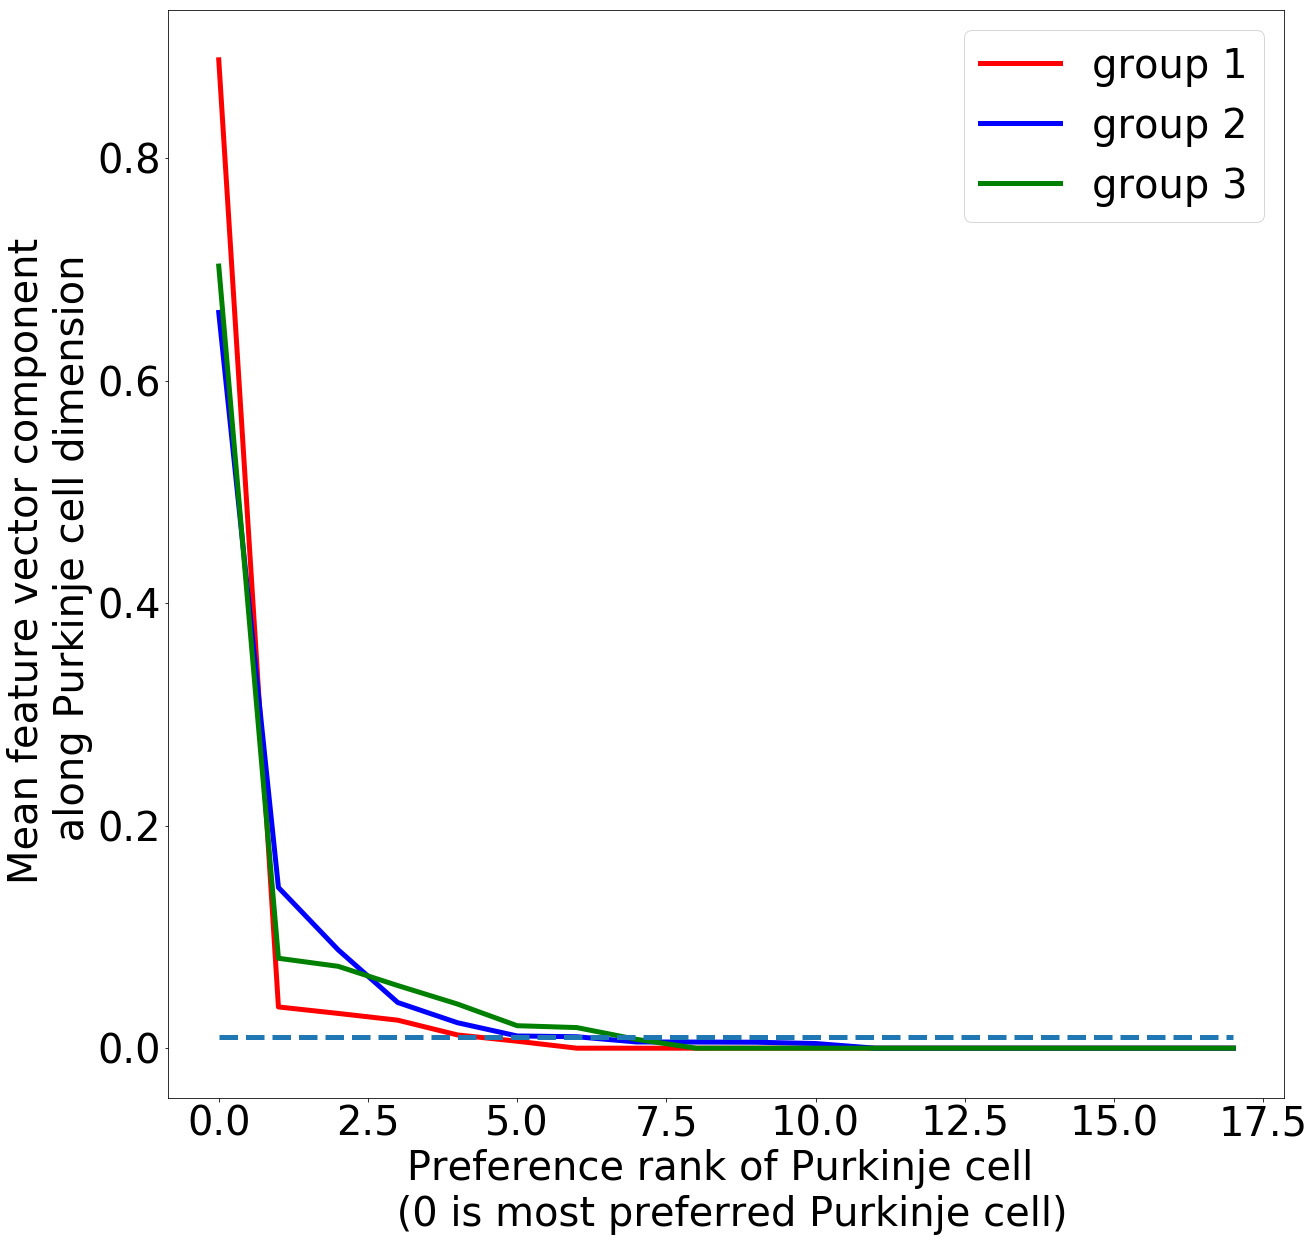

Preferred Purkinje cells in order of decreasing preference
Group 1:  ['17', '1', '4', '22', '20']
Group 2:  ['25', '1', '3', '4', '7', '5', '8']
Group 3:  ['1', '25', '4', '2', '17', '27', '3']


In [77]:
g1rows = np.arange(0,4)
g2rows = np.arange(4,11)
g3rows = np.arange(11,14) # the rest of the climbing fiber branches are not well grouped

p7cnog1 = p7clno[g1rows,:]
p7cnog2 = p7clno[g2rows,:]
p7cnog3 = p7clno[g3rows,:]

# Rank PCs by getting the average feature vector component along each dimension and then sorting
wg1 = np.mean(p7cnog1,axis=0)
wg2 = np.mean(p7cnog2,axis=0)
wg3 = np.mean(p7cnog3,axis=0)

# Sort weights in descending order
wg1sids = [q for q in reversed(list(np.argsort(wg1)))]
wg2sids = [q for q in reversed(list(np.argsort(wg2)))]
wg3sids = [q for q in reversed(list(np.argsort(wg3)))]

# Sort the actual means and then plot them so you have some idea of how to cut off your list of preferred
# Purkinje cells.
wg1s = [wg1[q] for q in wg1sids]
wg2s = [wg2[q] for q in wg2sids]
wg3s = [wg3[q] for q in wg3sids]

# Set a threshold by which to cut off the preferred Purkinje cells so that you don't included those
# for which there is essentially no more preference
threshmean = 0.01
plt.figure(figsize=(20,20))
plt.plot(np.arange(len(wg1s)),wg1s,'r',label='group 1')
plt.plot(np.arange(len(wg2s)),wg2s,'b',label='group 2')
plt.plot(np.arange(len(wg3s)),wg3s,'g',label='group 3')
plt.plot(np.arange(len(wg1s)),np.tile(threshmean,(len(wg1s),1)),'--')
plt.xlabel('Preference rank of Purkinje cell \n (0 is most preferred Purkinje cell)')
plt.ylabel('Mean feature vector component \n along Purkinje cell dimension')
plt.legend(loc='best')
plt.show()

# Make cutoffs in lists of preferred Purkinje cells for each group of climbing fiber branches
cutoff1 = np.min([i for i,q in enumerate(wg1s) if q < threshmean])
cutoff2 = np.min([i for i,q in enumerate(wg2s) if q < threshmean])
cutoff3 = np.min([i for i,q in enumerate(wg3s) if q < threshmean])
# print(cutoff1,cutoff2,cutoff3) # debugging

# Get preferred PCs in order of decreasing preference
prefpcg1 = [p7pclabels[q] for q in wg1sids]
prefpcg2 = [p7pclabels[q] for q in wg2sids]
prefpcg3 = [p7pclabels[q] for q in wg3sids]

# Cut populations of preferred Purkinje cells to only include those up to the cutoffs
prefpcg1 = prefpcg1[0:cutoff1]
prefpcg2 = prefpcg2[0:cutoff2]
prefpcg3 = prefpcg3[0:cutoff3]

print('Preferred Purkinje cells in order of decreasing preference')
print('Group 1: ',prefpcg1)
print('Group 2: ',prefpcg2)
print('Group 3: ',prefpcg3)

Randomize the numbers of synapses formed by each of the large-synapse cf segs onto each of their pc targets and reorder again to see whether the block diagonal structure comes up

In [34]:
nperm = 10000
wrs_p_perm = []
dgd_med_perm = []
dgd_skew_perm = []
dgd_std_perm = []
dgd_90pc_perm = []
dgd_95pc_perm = []
dgd_99pc_perm = []
for i in range(nperm):
    p7cperm = np.zeros([1,p7cl.shape[1]]) # start with a dummy row so the shape is right for appending rows
#     print(p7cperm.shape)
    # Rearrange the targets of each cf separately
    for cf in range(p7cl.shape[0]):
        resample = True # create a sample row and keep doing it until there is >=1 connection with >minnsyns
        while resample == True:
            # Find nonzero elements in the current row
            rowcurr = np.expand_dims(p7cl[cf,:],axis=0)
            nzrows,nzcols = np.where(rowcurr != 0)
            # Rather than permuting the observed values (which are few in number) for a cf,
            # assign new values from the p7 distribution by random sampling with replacement

    #         colpermid = np.random.permutation(len(nzcols))
            newrow = np.zeros((rowcurr.shape[0],rowcurr.shape[1]))
            for rid in range(len(nzcols)):
                nsynidcurr = np.random.randint(len(p7cnz))
                nsynscurr = p7cnz[nsynidcurr]
                newrow[nzrows[rid],nzcols[rid]] = nsynscurr
            # check whether there is at least one large connection by our criterion in the generated row
            # if not, generate a new row
            if len(np.where(newrow > minnsyns)[0]) > 0:
                resample = False
        # normalize the newly sampled row
        normfactcurr = np.sum(newrow,axis=1)
        newrow = np.divide(newrow,normfactcurr)
        p7cperm = np.append(p7cperm,newrow,axis=0)
    # remove the dummy row
    p7cperm = np.delete(p7cperm,0,axis=0)
#     print(p7cl) # debugging
#     print('\n') # debugging
#     print(p7cperm) # debugging
    # generate square, Euclidean distance matrix for the randomized connectivity matrix
    p7cpermdsq = squareform(pdist(p7cperm,'euclidean'))
    # compute block diagonal ordering
    p7lnoperm,p7lneworderperm,p7linkperm = compute_serial_matrix(p7cpermdsq,method='ward',metric='euclidean')
    # measure degree of block diagonal-ness    
    p7cfnopermlabels = [str(p7al[q][0]) for q in p7lneworderperm]
    # compute distances that link cfs in this permuted connectivity matrix
    dnpermcurr = dendrogram(p7linkperm,no_plot=True)
    dg_dists_perm = [q[1]-q[0] for q in dnpermcurr['dcoord']]
    wrs_p_perm.append(st.ranksums(dg_dists_obs,dg_dists_perm)[1]) # p-value from the wilcoxon rank sum test
    dgd_med_perm.append(np.median(dg_dists_perm))
    dgd_skew_perm.append(st.skew(dg_dists_perm))
    dgd_std_perm.append(np.std(dg_dists_perm))
    dgd_90pc_perm.append(np.percentile(dg_dists_perm,90))
    dgd_95pc_perm.append(np.percentile(dg_dists_perm,95))
    dgd_99pc_perm.append(np.percentile(dg_dists_perm,99))

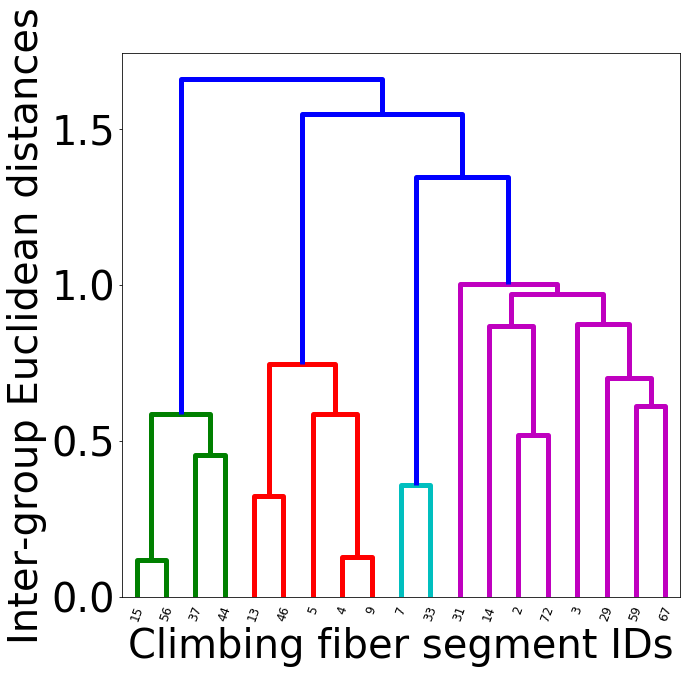

In [35]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
dnpermcurr = dendrogram(p7linkperm)
cflabelsforfig = [p7al[q][0] for q in dnpermcurr['leaves']]
ax.set_xticklabels(cflabelsforfig,rotation=70)
ax.set_xlabel('Climbing fiber segment IDs')
ax.set_ylabel('Inter-group Euclidean distances')
plt.show()

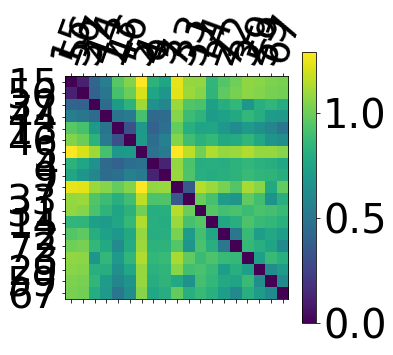

In [36]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(p7lnoperm)
fig.colorbar(cax)
ax.set_xticks([q for q in range(p7lnoperm.shape[0])])
ax.set_yticks([q for q in range(p7lnoperm.shape[0])])
ax.set_xticklabels(p7cfnopermlabels,rotation=70)
ax.set_yticklabels(p7cfnopermlabels,rotation=0)
plt.show()

Inspect distribution parameters for hierarchical clustering heights for permuted and observed connectivity matrices

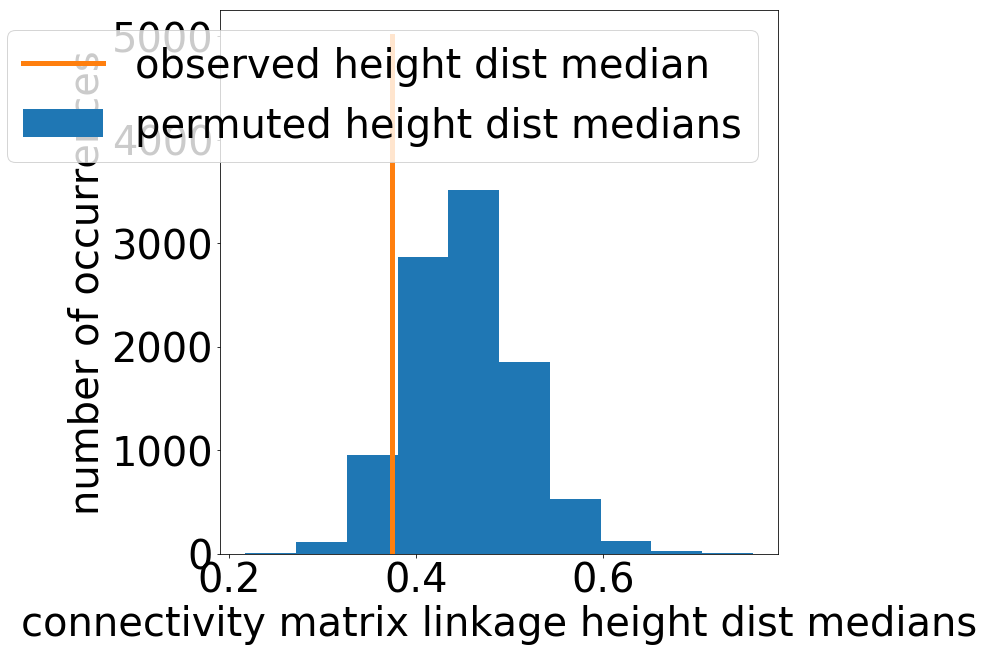

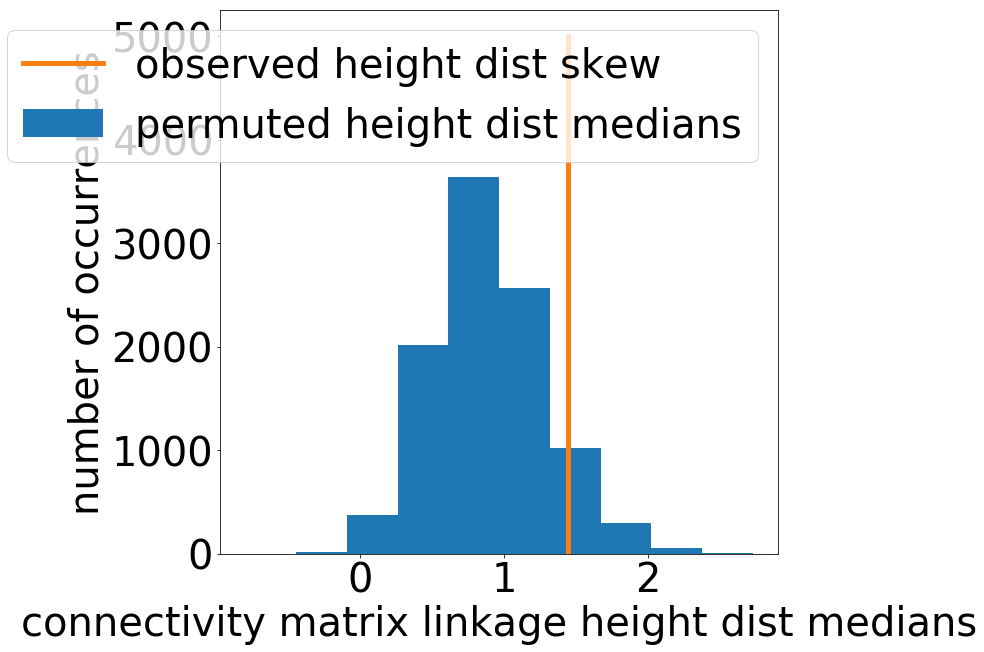

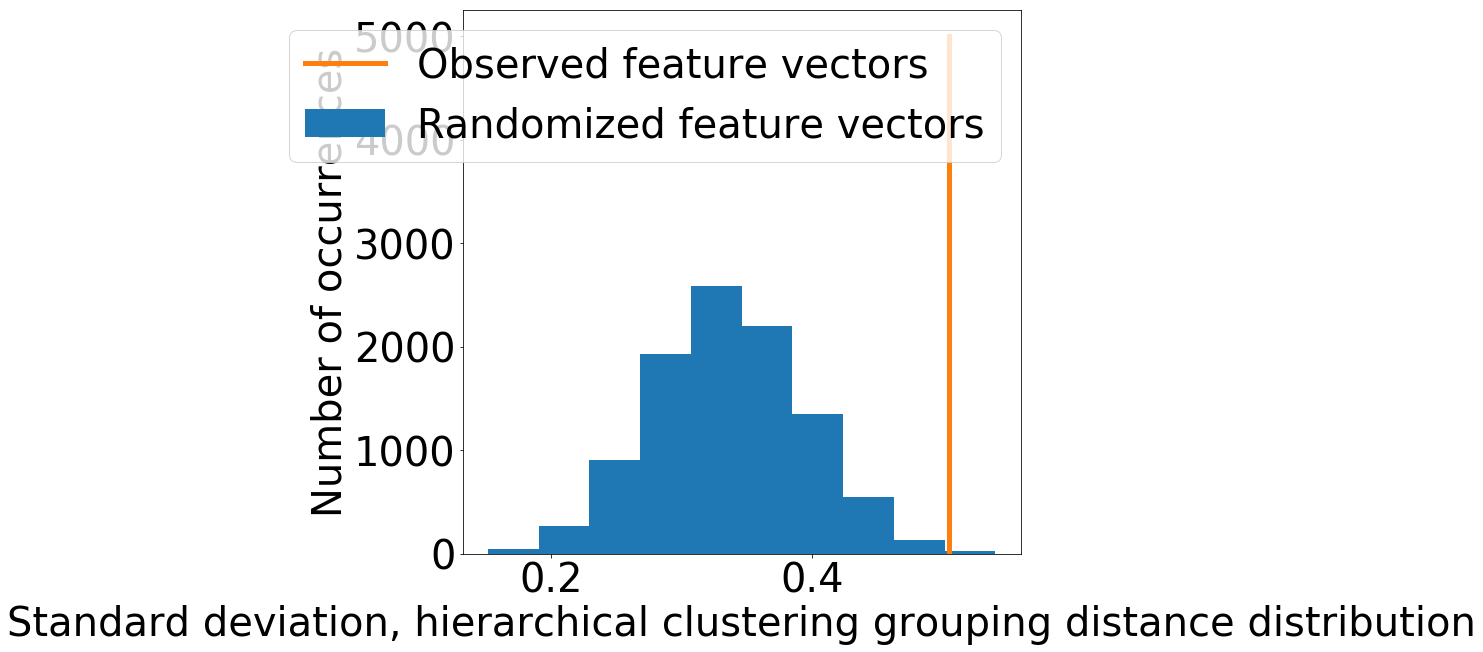

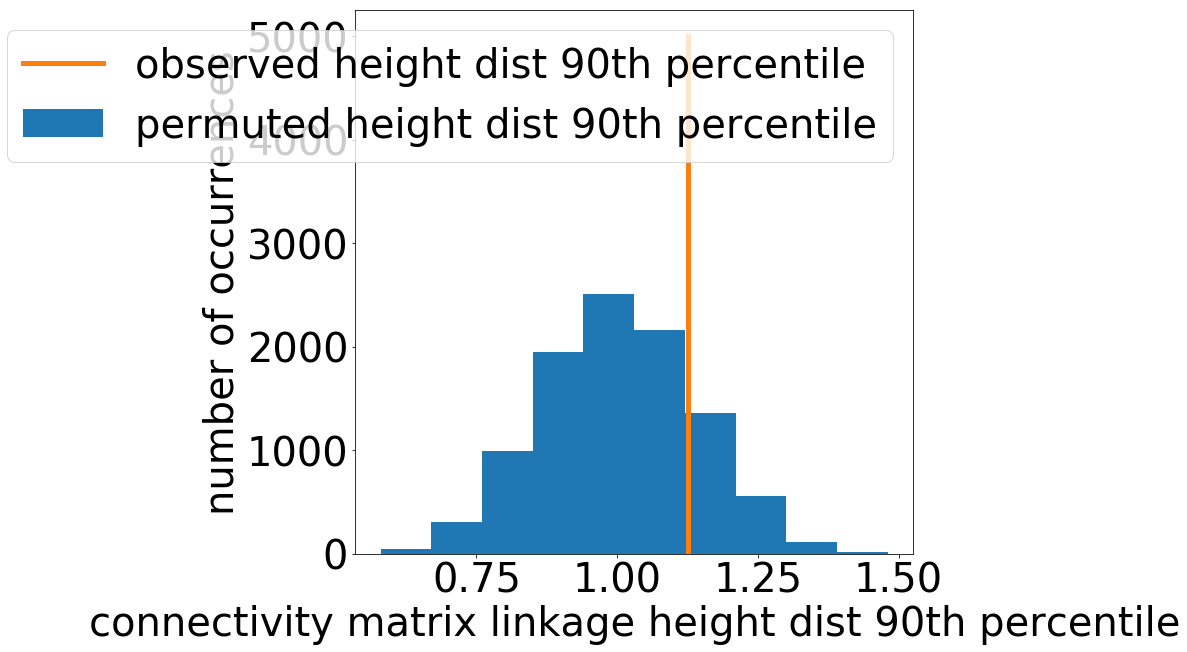

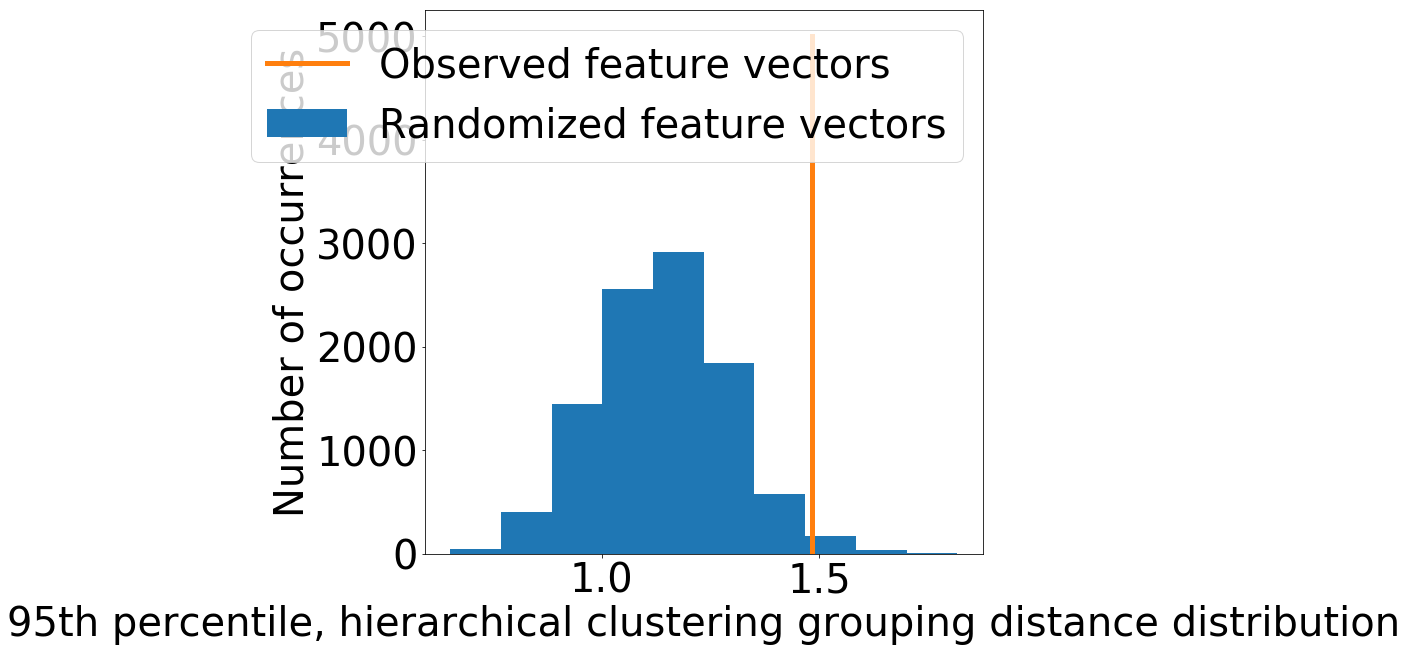

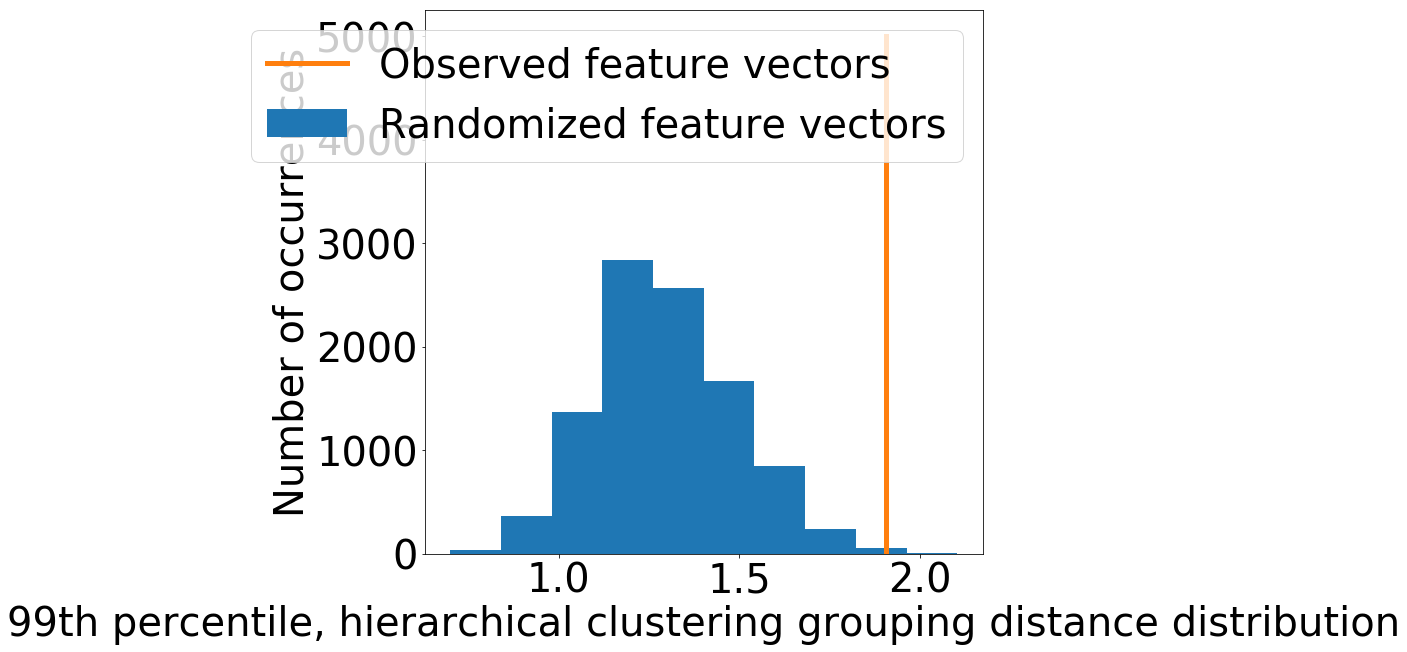

In [37]:
# # Wilcoxon rank-sum p-values
# alpha = 0.05
# plt.figure()
# plt.hist(wrs_p_perm)
# plt.plot([alpha,alpha],[0,nperm/2],'o-',marker='None')
# plt.show()

# medians
plt.figure(figsize=(10,10))
plt.hist(dgd_med_perm,label='permuted height dist medians')
plt.plot([dgd_med_obs,dgd_med_obs],[0,nperm/2],'o-',marker='None',label='observed height dist median')
plt.xlabel('connectivity matrix linkage height dist medians')
plt.ylabel('number of occurrences')
plt.legend()
plt.show()

# skews
plt.figure(figsize=(10,10))
plt.hist(dgd_skew_perm,label='permuted height dist medians')
plt.plot([dgd_skew_obs,dgd_skew_obs],[0,nperm/2],'o-',marker='None',label='observed height dist skew')
plt.xlabel('connectivity matrix linkage height dist medians')
plt.ylabel('number of occurrences')
plt.legend()
plt.show()

# standard deviations
plt.figure(figsize=(10,10))
plt.hist(dgd_std_perm,label='Randomized feature vectors')
plt.plot([dgd_std_obs,dgd_std_obs],[0,nperm/2],'o-',marker='None',label='Observed feature vectors')
plt.xlabel('Standard deviation, hierarchical clustering grouping distance distribution')
plt.ylabel('Number of occurrences')
plt.legend()
plt.show()

# 90th percentile of distribution (we want to know what the largest distances are)
plt.figure(figsize=(10,10))
plt.hist(dgd_90pc_perm,label='permuted height dist 90th percentile')
plt.plot([dgd_90pc_obs,dgd_90pc_obs],[0,nperm/2],'o-',marker='None',label='observed height dist 90th percentile')
plt.xlabel('connectivity matrix linkage height dist 90th percentile')
plt.ylabel('number of occurrences')
plt.legend()
plt.show()

# 95th percentile of distribution (we want to know what the largest distances are)
plt.figure(figsize=(10,10))
plt.hist(dgd_95pc_perm,label='Randomized feature vectors')
plt.plot([dgd_95pc_obs,dgd_95pc_obs],[0,nperm/2],'o-',marker='None',label='Observed feature vectors')
plt.xlabel('95th percentile, hierarchical clustering grouping distance distribution')
plt.ylabel('Number of occurrences')
plt.legend()
plt.show()

# 99th percentile of distribution (we want to know what the largest distances are)
plt.figure(figsize=(10,10))
plt.hist(dgd_99pc_perm,label='Randomized feature vectors')
plt.plot([dgd_99pc_obs,dgd_99pc_obs],[0,nperm/2],'o-',marker='None',label='Observed feature vectors')
plt.xlabel('99th percentile, hierarchical clustering grouping distance distribution')
plt.ylabel('Number of occurrences')
plt.legend()
plt.show()

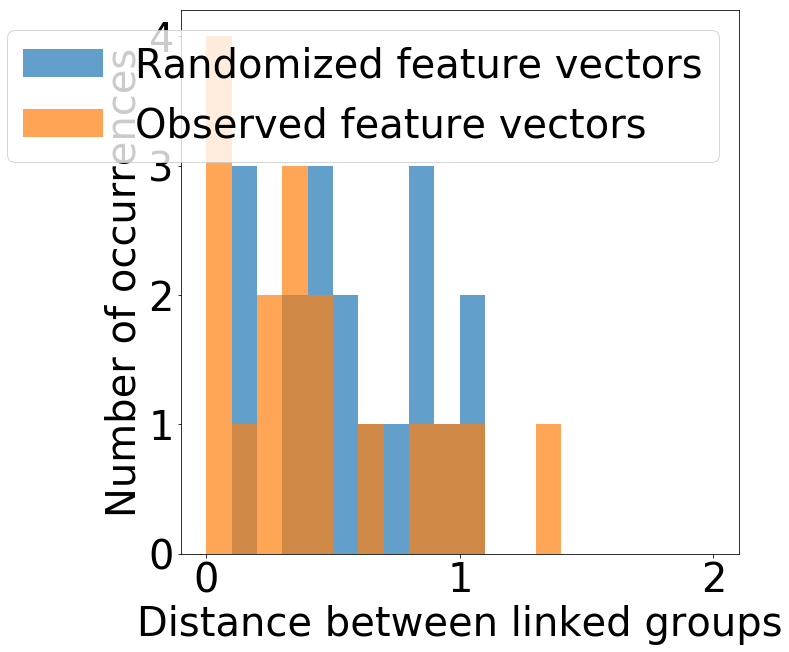

In [38]:
bin_edges = np.arange(0,210,10)*0.01
plt.figure(figsize = (10,10))
plt.hist(dg_dists_perm,bins=bin_edges,alpha = 0.7,label='Randomized feature vectors')
plt.hist(dg_dists_obs,bins=bin_edges,alpha = 0.7,label='Observed feature vectors')
plt.xlabel('Distance between linked groups')
plt.ylabel('Number of occurrences')
plt.legend()
plt.show()

Determine the proportion of values that are more extreme than the observed in both cases

In [39]:
# medians
print('medians:')
avg_med_perm = np.mean(dgd_med_perm)
print(avg_med_perm)
dists_avg_m_perm = [q - avg_med_perm for q in dgd_med_perm]
dist_avg_m_obs = dgd_med_obs - avg_med_perm
if dist_avg_m_obs < 0:
    frac_ex_med = len([q for q in dists_avg_m_perm if q < dist_avg_m_obs])/len(dists_avg_m_perm)
else:
    frac_ex_med = len([q for q in dists_avg_m_perm if q > dist_avg_m_obs])/len(dists_avg_m_perm)
print(frac_ex_med)

# skews
print('skews:')
avg_skew_perm = np.mean(dgd_skew_perm)
print(avg_skew_perm)
dists_avg_sk_perm = [q - avg_skew_perm for q in dgd_skew_perm]
dist_avg_sk_obs = dgd_skew_obs - avg_skew_perm
if dist_avg_sk_obs < 0:
    frac_ex_sk = len([q for q in dists_avg_sk_perm if q < dist_avg_sk_obs])/len(dists_avg_sk_perm)
else:
    frac_ex_sk = len([q for q in dists_avg_sk_perm if q > dist_avg_sk_obs])/len(dists_avg_sk_perm)
print(frac_ex_sk)

# standard deviations
print('standard deviations:')
avg_std_perm = np.mean(dgd_std_perm)
print(avg_std_perm)
dists_avg_s_perm = [q - avg_std_perm for q in dgd_std_perm]
dist_avg_s_obs = dgd_std_obs - avg_std_perm
if dist_avg_s_obs < 0:
    frac_ex_std = len([q for q in dists_avg_s_perm if q < dist_avg_s_obs])/len(dists_avg_s_perm)
else:
    frac_ex_std = len([q for q in dists_avg_s_perm if q > dist_avg_s_obs])/len(dists_avg_s_perm)
print(frac_ex_std)

# 90th percentiles
print('90th percentiles:')
avg_90pc_perm = np.mean(dgd_90pc_perm)
print(avg_90pc_perm)
dists_avg_90pc_perm = [q - avg_90pc_perm for q in dgd_90pc_perm]
dist_avg_90pc_obs = dgd_90pc_obs - avg_90pc_perm
if dist_avg_90pc_obs < 0:
    frac_ex_90pc = len([q for q in dists_avg_90pc_perm if q < dist_avg_90pc_obs])/len(dists_avg_90pc_perm)
else:
    frac_ex_90pc = len([q for q in dists_avg_90pc_perm if q > dist_avg_90pc_obs])/len(dists_avg_90pc_perm)
print(frac_ex_90pc)

# 95th percentiles
print('95th percentiles:')
avg_95pc_perm = np.mean(dgd_95pc_perm)
print(avg_95pc_perm)
dists_avg_95pc_perm = [q - avg_95pc_perm for q in dgd_95pc_perm]
dist_avg_95pc_obs = dgd_95pc_obs - avg_95pc_perm
if dist_avg_95pc_obs < 0:
    frac_ex_95pc = len([q for q in dists_avg_95pc_perm if q < dist_avg_95pc_obs])/len(dists_avg_95pc_perm)
else:
    frac_ex_95pc = len([q for q in dists_avg_95pc_perm if q > dist_avg_95pc_obs])/len(dists_avg_95pc_perm)
print(frac_ex_95pc)

# 99th percentiles
print('99th percentiles:')
avg_99pc_perm = np.mean(dgd_99pc_perm)
print(avg_99pc_perm)
dists_avg_99pc_perm = [q - avg_99pc_perm for q in dgd_99pc_perm]
dist_avg_99pc_obs = dgd_99pc_obs - avg_99pc_perm
if dist_avg_99pc_obs < 0:
    frac_ex_99pc = len([q for q in dists_avg_99pc_perm if q < dist_avg_99pc_obs])/len(dists_avg_99pc_perm)
else:
    frac_ex_99pc = len([q for q in dists_avg_99pc_perm if q > dist_avg_99pc_obs])/len(dists_avg_99pc_perm)
print(frac_ex_99pc)

medians:
0.4522506987380485
0.0891
skews:
0.8916604835917846
0.0874
standard deviations:
0.3363603071181371
0.0028
90th percentiles:
1.0040814669609297
0.1946
95th percentiles:
1.139532491438576
0.0173
99th percentiles:
1.2968942055691512
0.0017


Inspect distances between climbing fibers when this reordering is done and compare with the observed distribution

In [40]:
# plt.figure()
# plt.hist(p7cld,alpha=0.7,label='observed connectivity')
# plt.hist(squareform(p7cpermdsq),alpha=0.7,label='permuted connectivity') # flattening
# plt.legend()
# plt.show()

***